In [1]:
import utils
import plotting
import numpy as np
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
from sample_labels import sig_key, data_key

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from PyPDF2 import PdfFileMerger

from copy import deepcopy

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = "../../../plots/ttsfs/23Feb1"

import os

_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
samples = {
    "QCD": "QCD",
    "Single Top": "ST",
    "TTSL": "TTToSemiLeptonic",
    "TTbar": ["TTTo2L2Nu", "TTToHadronic"],
    "W+Jets": "WJets",
    "Diboson": ["WW", "WZ", "ZZ"],
    "Data": "SingleMuon",
}

top_matched_key = "TT Top Matched"

# data_dir = "../../../../data/ttsfs/Dec22/"
data_dir = "../../../../data/ttsfs/Jan31/"
year = "2018"

# filters = [("('ak8FatJetPt', '0')", ">=", 500)]
filters = None

events_dict = utils.load_samples(data_dir, samples, year, filters=filters)

Finding QCD samples
Loading QCD_HT300to500
Loaded 0 entries
Loading QCD_HT200to300
Loaded 0 entries
Loading QCD_HT700to1000
Loaded 490 entries
Loading QCD_HT1000to1500
Loaded 517 entries
Loading QCD_HT100to200
Loaded 0 entries
Loading QCD_HT2000toInf
Loaded 251 entries
Loading QCD_HT1500to2000
Loaded 585 entries
Loading QCD_HT50to100
Loaded 0 entries
Loading QCD_HT500to700
Loaded 0 entries
Finding Single Top samples
Loading ST_tW_antitop_5f_NoFullyHadronicDecays
Loaded 14575 entries
Loading ST_tW_top_5f_NoFullyHadronicDecays
Loaded 14842 entries
Loading ST_t-channel_top_4f_InclusiveDecays
Loaded 24887 entries
Loading ST_tW_top_5f_inclusiveDecays
Loaded 5649 entries
Loading ST_tW_antitop_5f_inclusiveDecays
Loaded 5431 entries
Loading ST_s-channel_4f_leptonDecays
Loaded 14524 entries
Loading ST_t-channel_top_5f_InclusiveDecays
Loaded 23014 entries
Loading ST_t-channel_antitop_4f_InclusiveDecays
Loaded 9837 entries
Loading ST_t-channel_antitop_5f_InclusiveDecays
Loaded 7840 entries
Findin

In [5]:
data_dir = "../../../../data/ttsfs/Jan17/"
sample = "TTToSemiLeptonic"

# utils.get_cutflow(f"{data_dir}/{year}/TTToSemiLeptonic/pickles", year, "TTToSemiLeptonic")
utils.get_cutflow(f"{data_dir}/{year}/{sample}/pickles", year, sample)

# import pickle

# for i in range(68):
#     with open(f"{data_dir}/{year}/{sample}/pickles/out_{i}.pkl", "rb") as file:
#         out_dict = pickle.load(file)[year][sample]['cutflow']
#         print(out_dict["all"])
# utils.get_cutflow(f"{data_dir}/{year}/{sample}/pickles", year, sample)

OrderedDict([('ak4_jet', 1073887.0),
             ('ak8_jet', 1798382.0),
             ('muon', 11213765.0),
             ('npvsGood', 16197479.0),
             ('all', 126125558),
             ('met', 6254499.0),
             ('top_has_bs', 1073061.0),
             ('trigger', 16197479.0),
             ('lepW', 6254499.0)])

In [6]:
data_dir = "../../../../data/ttsfs/Jan19/"

# utils.get_cutflow(f"{data_dir}/{year}/TTToSemiLeptonic/pickles", year, "TTToSemiLeptonic")
utils.get_cutflow(f"{data_dir}/{year}/{sample}/pickles", year, sample)

# import pickle

# with open(f"{data_dir}/{year}/{sample}/pickles/out_1.pkl", "rb") as file:
#     out_dict = pickle.load(file)[year][sample]['cutflow']
#     print(out_dict)

OrderedDict([('ak4_jet', 214814.0),
             ('ak8_jet', 313658.0),
             ('muon', 11213765.0),
             ('npvsGood', 16197479.0),
             ('all', 126125558),
             ('met', 6254499.0),
             ('top_has_bs', 214620.0),
             ('trigger', 16197479.0),
             ('lepW', 6254499.0)])

In [7]:
events_dict[top_matched_key] = events_dict["TTSL"].loc[events_dict["TTSL"]["top_matched"][0] == 1]
events_dict["TT W Matched"] = events_dict["TTSL"].loc[events_dict["TTSL"]["w_matched"][0] == 1]
events_dict["TT Unmatched"] = pd.concat(
    [events_dict["TTbar"], events_dict["TTSL"].loc[events_dict["TTSL"]["unmatched"][0] == 1]]
)
# del events_dict["TTSL"]
# del events_dict["TTbar"]

In [8]:
# normalize scale factors to average to 1
for key in ["lp_sf", "lp_sf_lnN", "lp_sf_sys_down", "lp_sf_sys_up"]:
    # cut off at 10
    events_dict[top_matched_key].loc[:, key] = np.minimum(
        events_dict[top_matched_key].loc[:, key].values, 10
    )
    mean_lp_sfs = np.mean(np.nan_to_num(events_dict[top_matched_key][key]), axis=0)
    events_dict[top_matched_key].loc[:, key] = (
        np.nan_to_num(events_dict[top_matched_key].loc[:, key]) / mean_lp_sfs
    )

Text(0.5, 1.0, 'Scale factor distribution')

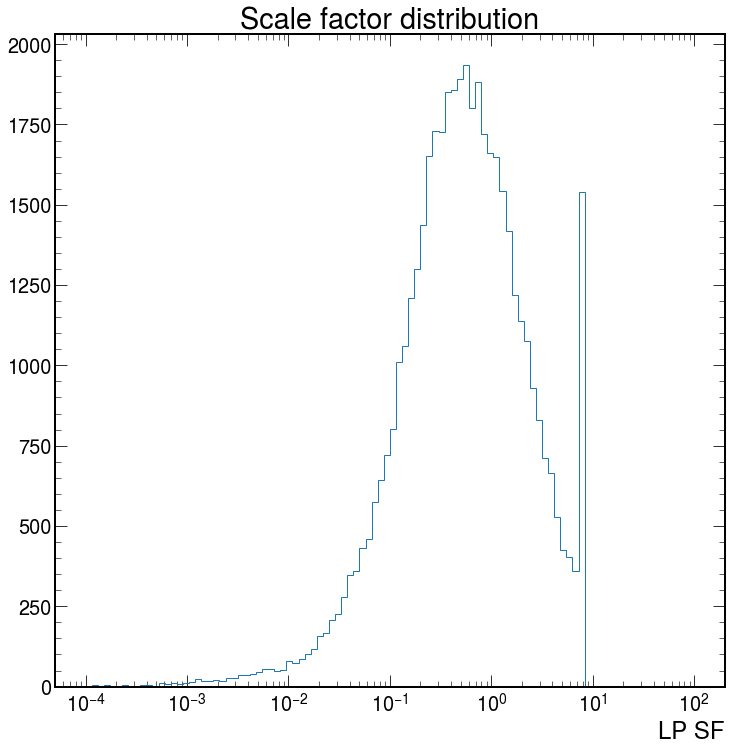

In [11]:
plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 12))
_ = plt.hist(
    events_dict[top_matched_key]["lp_sf"][10].values,
    np.logspace(-4, 2, 101, base=10),
    histtype="step",
)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("LP SF")
plt.title("Scale factor distribution")

In [ ]:
for key in events_dict:
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetPt"][0] >= 500]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] >= 125]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] <= 225]

In [ ]:
events = events_dict[top_matched_key]
sj_matching_unc = (
    (np.sum(events["lp_sf_unmatched_quarks"]) / (len(events) * 3))
    + (np.sum(events["lp_sf_double_matched_event"]) / (len(events)))
).values[0]
sj_pt_unc = (np.sum(events["lp_sf_num_sjpt_gt350"]) / (len(events))).values[0] * 0.21

In [ ]:
sj_matching_unc

In [ ]:
sj_pt_unc

In [ ]:
plot_samples = [
    "QCD",
    "Diboson",
    "Single Top",
    "W+Jets",
    "TT Unmatched",
    "TT W Matched",
    top_matched_key,
]

### Pre plots

In [ ]:
# {var: (bins, label)}
plot_vars = {
    "ak8FatJetMass": ([20, 125, 225], r"$m_{SD}$ (GeV)"),
    "ak8FatJetPt": ([20, 500, 1200], r"$p_T$ (GeV)"),
    "ak8FatJetnPFCands": ([20, 0, 120], r"# of PF Candidates"),
    "ak8FatJetParticleNet_Th4q": ([20, 0.6, 1], r"ParticleNet $T_{H4q}$ Non-MD"),
    "ak8FatJetParTMD_THWW4q": ([20, 0.6, 1], r"ParT $T_{HWW4q}$ MD"),
    "tau21": ([20, 0.04, 0.8], r"$\tau_{21}$"),
    "tau32": ([20, 0.2, 1], r"$\tau_{32}$"),
    "tau43": ([20, 0.42, 1], r"$\tau_{43}$"),
    "tau42": ([20, 0, 1], r"$\tau_{42}$"),
    "tau41": ([20, 0, 1], r"$\tau_{41}$"),
}

pre_hists = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists:
        pre_hists[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfFileMerger()

for var, var_hist in pre_hists.items():
    name = f"{plot_dir}/pre_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=None,
        name=name,
    )
    merger_pre_plots.append(name)

merger_pre_plots.write(f"{plot_dir}/PrePlots.pdf")
merger_pre_plots.close()

### Post plots

In [ ]:
post_hists = {}
post_hists_err = {}
uncs_dict = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    # if var not in post_hists:
    toy_hists = []
    for i in range(events["lp_sf"].shape[1]):
        toy_hists.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events["lp_sf"][i].values,
            )[0]
        )

    sys_up_down = []
    for key in ["lp_sf_sys_up", "lp_sf_sys_down"]:
        sys_up_down.append(
            np.histogram(
                events[var][0].values.squeeze(),
                np.linspace(*bins[1:], bins[0] + 1),
                weights=events["weight"][0].values * events[key][0].values,
            )[0]
        )

    nom_vals = toy_hists[0]  # first column are nominal values

    uncs = {
        "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)),  # cap at 100% unc
        "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2),
        "syst_sjm_unc": nom_vals * sj_matching_unc,
        "syst_sjpt_unc": nom_vals * sj_pt_unc,
    }

    uncs_dict[var] = uncs

    unc = np.linalg.norm(list(uncs.values()), axis=0)

    thist = deepcopy(pre_hists[var])
    top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
    thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
    post_hists[var] = thist
    post_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/post_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

merger_post_plots.write(f"{plot_dir}/PostPlots.pdf")
merger_post_plots.close()

### Post LnN Plots

In [ ]:
post_lnN_hists = {}
post_lnN_hists_err = {}
uncs_lnN_dict = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_lnN_hists:
        toy_hists = []
        for i in range(events["lp_sf_lnN"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_lnN"][i].values,
                )[0]
            )

        sys_up_down = []
        for key in ["lp_sf_sys_up", "lp_sf_sys_down"]:
            sys_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events[key][0].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values

        uncs = {
            "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)),  # cap at 100% unc
            "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2),
            "syst_sjm_unc": nom_vals * sj_matching_unc,
            "syst_sjpt_unc": nom_vals * sj_pt_unc,
        }

        uncs_lnN_dict[var] = uncs

        unc = np.linalg.norm(list(uncs.values()), axis=0)

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_lnN_hists[var] = thist

        post_lnN_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_lnN_hists.items():
    name = f"{plot_dir}/postlnN_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_lnN_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

merger_post_plots.write(f"{plot_dir}/PostLnNPlots.pdf")
merger_post_plots.close()

In [36]:
binn = -1
tvar = "ak8FatJetParTMD_THWW4q"
pre_vals = pre_hists[tvar].view(flow=False)[top_matched_key_index, :].value
nom_vals = post_hists[tvar].view(flow=False)[top_matched_key_index, :].value
unc = post_hists_err[tvar]
print("SF: ", nom_vals[binn] / pre_vals[binn])
print("Uncs: ", {key: val[binn] / nom_vals[binn] * 100 for key, val in uncs_dict[tvar].items()})
print("Combined: ", unc[binn] / nom_vals[binn] * 100)
print("Abs: ", unc[binn] / pre_vals[binn])

SF:  0.9454609916441871
Uncs:  {'stat_unc': 7.671583522379341, 'syst_rat_unc': 11.47522796374204, 'syst_sjm_unc': 6.821087463337595, 'syst_sjpt_unc': 5.308039407385124}
Combined:  16.286085075718603
Abs:  0.15397858145690504


In [37]:
binn = -1
tvar = "ak8FatJetParTMD_THWW4q"
pre_vals = pre_hists[tvar].view(flow=False)[top_matched_key_index, :].value
nom_vals = post_lnN_hists[tvar].view(flow=False)[top_matched_key_index, :].value
unc = post_lnN_hists_err[tvar]
print("SF: ", nom_vals[binn] / pre_vals[binn])
print("Uncs: ", {key: val[binn] / nom_vals[binn] * 100 for key, val in uncs_dict[tvar].items()})
print("Combined: ", unc[binn] / nom_vals[binn] * 100)
print("Abs: ", unc[binn] / pre_vals[binn])

SF:  0.9401747401835858
Uncs:  {'stat_unc': 7.714717971612027, 'syst_rat_unc': 11.539748885216932, 'syst_sjm_unc': 6.859439890843695, 'syst_sjpt_unc': 5.337884530712665}
Combined:  15.744204462622047
Abs:  0.14802303340042935


### Ratio plots

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


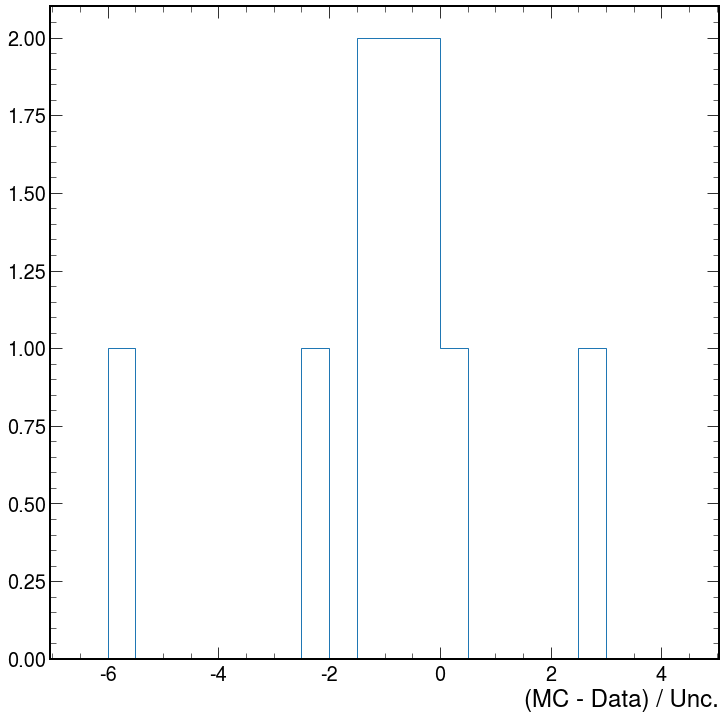

In [74]:
tvar = "ak8FatJetParTMD_THWW4q"

# plt.figure(figsize=(12, 12))
# hists = pre_hists[tvar]
# bg_tot = np.sum(hists[plot_samples, :].values(), axis=0)
# mcdata_ratio = (bg_tot + 1e-5) / hists[data_key, :].values()
# _ = plt.hist(mcdata_ratio - 1, np.linspace(-0.5, 0.5, 10), histtype='step')

plt.figure(figsize=(12, 12))
hists = post_hists[tvar]
bg_tot = np.sum(hists[plot_samples, :].values(), axis=0)
data_tot = hists[data_key, :].values()
unc = post_hists_err[tvar]
mcdata_ratio = (bg_tot) / data_tot
_ = plt.hist(((bg_tot - data_tot) / (unc))[10:], np.linspace(-6.5, 4.5, 23), histtype="step")
plt.xlabel("(MC - Data) / Unc.")
plt.savefig(f"{plot_dir}/pull_hist.pdf")

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


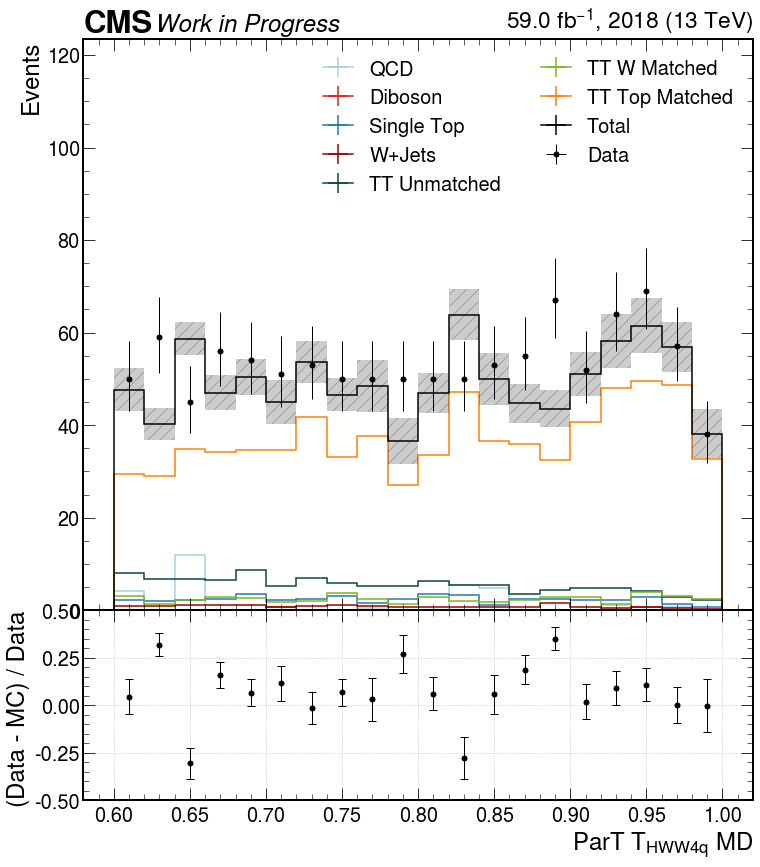

In [65]:
plotting.ratioLinePlot(
    post_hists[tvar],
    plot_samples,
    year,
    bg_err=post_hists_err[tvar],
    name=f"{plot_dir}/post_ak8FatJetParTMD_THWW4q_pulls.pdf",
    pulls=True,
)

In [82]:
cut_dict = {}

for key in events_dict:
    cut_dict[key] = events_dict[key][events_dict[key]["tau42"][0] <= 0.3]

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


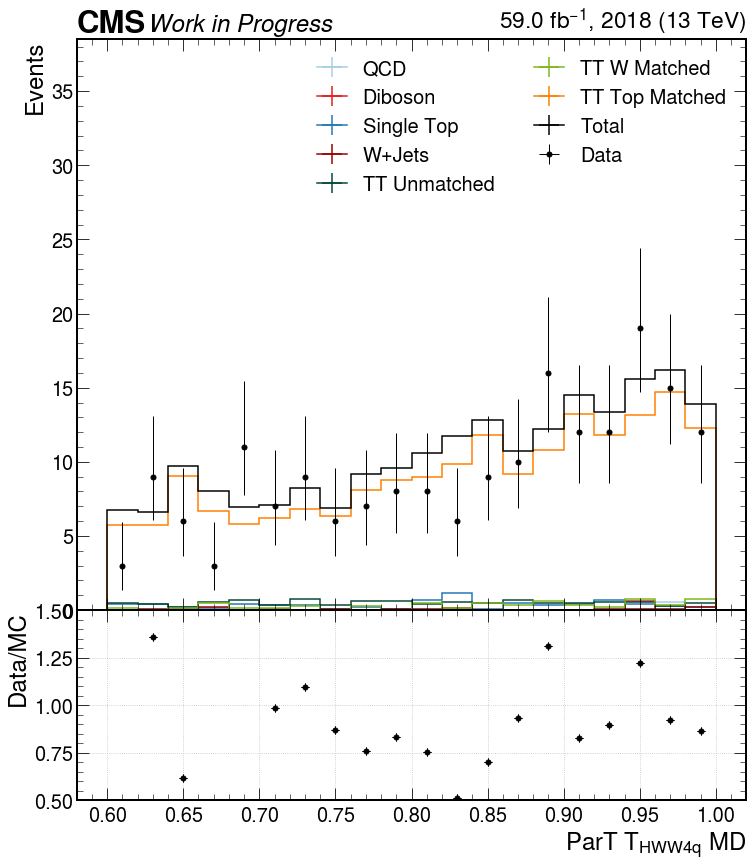

In [84]:
# {var: (bins, label)}
plot_vars = {
    "ak8FatJetParTMD_THWW4q": ([20, 0.6, 1], r"ParT $T_{HWW4q}$ MD"),
}

pre_hists_cut = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists_cut:
        pre_hists_cut[var] = utils.singleVarHistNoMask(
            cut_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfFileMerger()

for var, var_hist in pre_hists_cut.items():
    name = f"{plot_dir}/pre_{var}_tau42_cut.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=None,
        name=name,
    )
    merger_pre_plots.append(name)

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


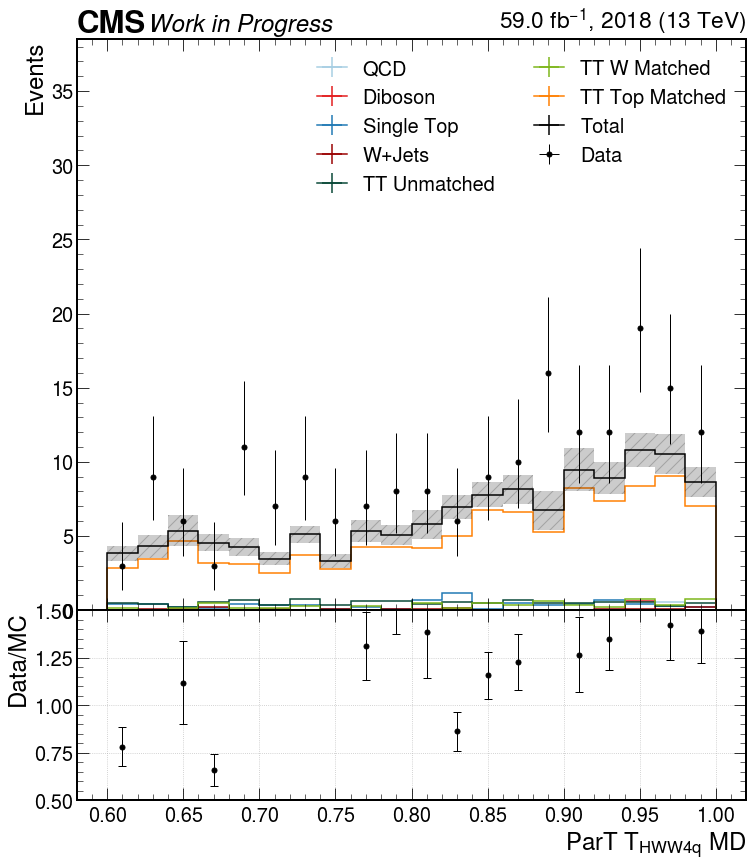

In [86]:
post_lnN_cut_hists = {}
post_lnN_cut_hists_err = {}
uncs_lnN_cut_dict = {}

events = cut_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_lnN_cut_hists:
        toy_hists = []
        for i in range(events["lp_sf_lnN"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_lnN"][i].values,
                )[0]
            )

        sys_up_down = []
        for key in ["lp_sf_sys_up", "lp_sf_sys_down"]:
            sys_up_down.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events[key][0].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values

        uncs = {
            "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)),  # cap at 100% unc
            "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2),
            "syst_sjm_unc": nom_vals * sj_matching_unc,
            "syst_sjpt_unc": nom_vals * sj_pt_unc,
        }

        uncs_lnN_cut_dict[var] = uncs

        unc = np.linalg.norm(list(uncs.values()), axis=0)

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_lnN_cut_hists[var] = thist

        post_lnN_cut_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_lnN_cut_hists.items():
    name = f"{plot_dir}/postlnN_{var}_cut.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_lnN_cut_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

In [ ]:
mass_hist = utils.singleVarHistNoMask(
    events_dict, "ak8FatJetMass", [20, 125, 225], r"$m_{SD}$", weight_key="weight"
)

In [ ]:
plotting.ratioHistPlot(
    mass_hist,
    ["QCD", "Diboson", "Single Top", "W+Jets", "TT Unmatched", "TT W Matched", top_matched_key],
    f"{plot_dir}/",
)